In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
# import math

import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!python -V

Python 3.11.5


In [3]:
def Frobenius(A,B):
    return torch.vmap(torch.trace)(torch.bmm(A,torch.transpose(B,1,2)))

# Random sample generation

In [4]:
t0 = time.time()
num_samples = 2**16
num_time_intervals=20
dim = 10
size = num_samples* dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))


It takes 106 ms to generate 13,107,200 iid samples.


In [5]:
num= 2**10
n=10
d = 3
iid[0:num*n*d].reshape([num,d,n])

tensor([[[-0.9173,  1.8104, -0.9492,  ..., -0.0586, -0.5073,  0.2676],
         [-0.8148,  0.0884, -0.5747,  ..., -0.2465,  0.1778, -0.5072],
         [-0.8962,  0.6600, -2.0709,  ...,  0.8919, -0.7202, -0.7052]],

        [[-1.7792, -1.8437,  0.3013,  ...,  2.0559,  0.2671,  0.0997],
         [ 0.3341, -0.0130, -0.0394,  ..., -0.4053, -1.1084, -0.3910],
         [-0.0544,  1.2813,  0.9382,  ...,  1.7692, -0.8846,  0.4407]],

        [[ 0.5353,  0.0291, -0.8502,  ...,  0.8958, -1.0667,  0.1203],
         [-0.1816,  1.0292,  0.2329,  ..., -1.9155,  1.0538,  0.8091],
         [-1.1635, -1.1021, -0.9081,  ..., -0.0276, -0.8968, -0.7001]],

        ...,

        [[-1.6151,  0.6157,  0.1644,  ...,  0.9240, -1.0374, -0.1238],
         [ 0.8765, -0.6611, -0.7202,  ..., -1.1796, -1.4998, -0.0310],
         [ 0.3859,  1.5372,  0.1768,  ...,  0.3070, -0.3493, -2.6729]],

        [[-0.5945, -1.2040, -0.5048,  ...,  1.0586,  0.5480,  1.5118],
         [-0.6556,  1.1495, -0.4651,  ...,  1.0280, -1.

# Parameters of the PDEs

In [6]:
dim=2 # dim = n+1, n assets, 1 wealth + n stochastic volatilites. does not include time
# nonlinear PDE
pde_params={'dim':dim,
          'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }
# nonlinear PDE with OU processes
pde_params0={'dim':dim,
          'kappa':torch.tensor([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }

In [7]:
x_tmp = torch.rand(10,dim+1)#test data. includes time variable
x_tmp.shape

torch.Size([10, 3])

# Parameters of simulation

In [8]:
sim_params={'num_samples':2**12,
          'num_time_intervals': 20,
          'iid':iid,
          'start' : torch.tensor([0.0]),  
          'end' : torch.tensor([1.0])
        }

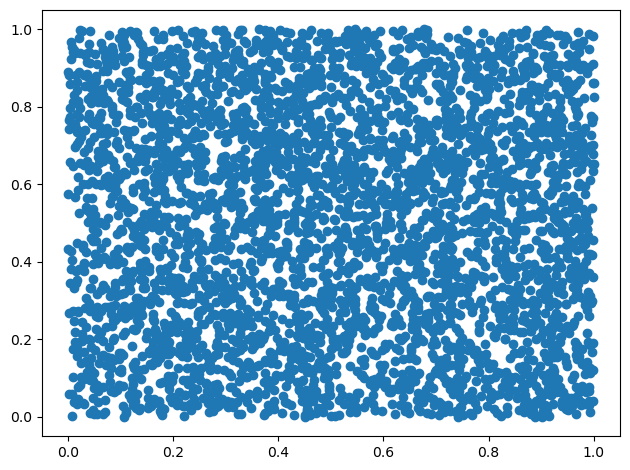

In [9]:
a = sim_params['start']
b = sim_params['end']
x0 = a+(b-a)*torch.rand(sim_params['num_samples'],dim).to(device)
plt.scatter(x0[:,0].numpy(),x0[:,dim-1].numpy());
plt.tight_layout(rect=[0,0,1,1]);

# Autograd for gradient and Hessian

## Gradient

In [10]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [11]:
def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    # hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    return Du

##  First derivative

In [12]:
def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    # hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    return Du

## Gradient

In [13]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [14]:
def grad_fn2(x,z,a,f,xx=False,r=False,p=False,alpha=False):  #output= [M,D,1], input: x=[M,D,1] z=[M,D,1], a=[M,D,D]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  zin=z.clone().detach()
  zin.requires_grad=True
  # print('zin shape', zin.shape)
  ain=a.clone().detach()
  ain.requires_grad=True
  # print('ain shape', ain.shape)
  # ain=torch.reshape(ain,(num_sample,dim*dim,1))
  u=f(xin,zin,ain)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  if xx==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if r==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[rin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],1,1))
    # Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  if p==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[zin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if alpha==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[ain],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  return Du

## Jacobian

Jacobian of the griadient $\nabla u:\mathbb{R}^d\to\mathbb{R}^d$ to find the Hessian $D^2 u$ (excluding time variable)

Jacobian of a function $u:\mathbb{R}^d\to\mathbb{R}$ to find the gradient $\nabla u$

In [15]:
class sample_Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sample_Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 10),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(10,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])       
dv = sample_Znet()
def test_fnc2(x):
    return x[:,1:]*x[:,1:] + torch.sin(torch.tensor([2])*torch.pi*x[:,1:])

In [16]:
class sample_Ytnet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sample_Ytnet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 10),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(10,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])       
dv = sample_Znet()

In [17]:
input = x_tmp
print(input.shape,dim)
test_fnc2(input).shape

torch.Size([10, 3]) 2


torch.Size([10, 2])

In [18]:
torch.sin(2*torch.pi*input)

tensor([[-0.9732, -0.3145,  0.8512],
        [-0.9982, -0.1638,  0.4888],
        [ 0.4458,  0.9984, -0.9741],
        [-0.7788,  0.3056, -0.8764],
        [ 0.7107,  0.5183,  0.6281],
        [ 0.9947,  0.6313, -0.7359],
        [ 0.9581, -0.8391,  0.5628],
        [-0.5752,  0.3150, -0.7245],
        [-0.9704, -0.5746, -0.9298],
        [-0.0613,  0.8079, -0.9688]])

In [19]:
output = jacobian(test_fnc2, input)
print(input.shape, test_fnc2(input).shape,output.shape)
for i in range(input.shape[0]):
    if i == 0:
        jac = output[0,:,0,1:].unsqueeze(0)# output[0,:,0,1:] eliminates the derivative wrt the first compinent, i.e., time derivative
        # print(output[i,:,i,:])
    else:
        # print(output[i,:,i,:].unsqueeze(0))
        jac = torch.cat((jac,output[i,:,i,1:].unsqueeze(0)))
print("Jacobians Tensor:\n", jac.shape)

torch.Size([10, 3]) torch.Size([10, 2]) torch.Size([10, 2, 10, 3])
Jacobians Tensor:
 torch.Size([10, 2, 2])


In [20]:
output[0,:,0,1:].shape

torch.Size([2, 2])

Jacobian of a function from $\mathbb{R}^d$ to $\mathbb{R}^d$, excludes time derivative

In [21]:
def sqr_jacobian(func,x):#Jacobian of a function from R^d to R^d
    xin=x.clone().detach()
    xin.requires_grad=True
    out = jacobian(func, xin)
    for i in range(x.shape[0]):
        if i == 0:
            jac = out[i,:,i,1:].unsqueeze(0)
            # print(output[i,:,i,:])
        else:
            # print(output[i,:,i,:].unsqueeze(0))
            jac = torch.cat((jac,out[i,:,i,1:].unsqueeze(0)))
    return jac
    

Jacobian of a function $u:\mathbb{R}^d\to\mathbb{R}$ to find the gradient $\nabla u$

In [22]:
def test_fnc(x):
    return torch.pow(x[:,1:],2).sum(axis=1).unsqueeze(-1)


In [23]:

jacobian(test_fnc,input)

tensor([[[[0.0000, 1.1018, 0.3241],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.9476, 0.1626],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.5181, 1.5726],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [24]:
jacobian(test_fnc,input)[0,:,0,1:],jacobian(test_fnc,input)[1,:,1,1:],2*input[:,1:]

(tensor([[1.1018, 0.3241]]),
 tensor([[1.9476, 0.1626]]),
 tensor([[1.1018, 0.3241],
         [1.9476, 0.1626],
         [0.5181, 1.5726],
         [0.9012, 1.6600],
         [0.1734, 0.2162],
         [0.2175, 1.2633],
         [1.3169, 0.8097],
         [0.8980, 1.7421],
         [1.1948, 1.6199],
         [0.7006, 1.4203]]))

In [25]:
def x_jacobian(func,x):#Jacobian of a function from R^d to R^d
    xin=x.clone().detach()
    xin.requires_grad=True
    out = jacobian(func, xin)
    print(out.shape)
    for i in range(x.shape[0]):
        if i == 0:
            jac = out[i,:,i,1:].unsqueeze(0)
            # print(out[i,i,1:])
        else:
            # print(out[i,i,:].shape)
            jac = torch.cat((jac,out[i,:,i,1:].unsqueeze(0)))
        if i%100 == 0:
            print(i)
    return jac.squeeze(1)

In [26]:
x_jacobian(test_fnc,input)

torch.Size([10, 1, 10, 3])
0


tensor([[1.1018, 0.3241],
        [1.9476, 0.1626],
        [0.5181, 1.5726],
        [0.9012, 1.6600],
        [0.1734, 0.2162],
        [0.2175, 1.2633],
        [1.3169, 0.8097],
        [0.8980, 1.7421],
        [1.1948, 1.6199],
        [0.7006, 1.4203]])

In [27]:
Yt_test = sample_Ytnet()
Yt_test(input)

tensor([[0.1553],
        [0.2825],
        [0.1199],
        [0.1446],
        [0.0998],
        [0.0941],
        [0.2574],
        [0.1504],
        [0.1623],
        [0.1349]], grad_fn=<AddmmBackward0>)

In [28]:
Yt_test

sample_Ytnet(
  (linear_stack): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [29]:
x_jacobian(Yt_test,input)

torch.Size([10, 1, 10, 3])
0


tensor([[ 0.2790, -0.0136],
        [ 0.2809, -0.0139],
        [ 0.2880,  0.0040],
        [ 0.2729, -0.0004],
        [ 0.3195,  0.0059],
        [ 0.3029,  0.0074],
        [ 0.3033, -0.0048],
        [ 0.2743, -0.0006],
        [ 0.2650, -0.0040],
        [ 0.2855,  0.0010]])

## Hessian

In [30]:
def hessian_model(t,x,model):
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    Du = model(xt_in)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp



In [31]:

def hessian1(x,model2z):  #x=[M,D,1]  output= [M,D,1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    # print("D2u shape:",hess_temp.shape)

    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    # print('this is xin')
    # print(xin)
    xin.requires_grad=True
    Du = model2z(xin.squeeze(2))
    # print('this is Du')
    # print(Du)
    # print('this is Du shape')
    # print(Du.shape)
    # print('this is Du 1')
    # print(Du[:,1,:])
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp




## First and second derivative together

In [32]:
def Grad_Hess(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    d = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],d,d).to(device)
    Du=torch.zeros(x.shape[0],d).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(d)],1)
    Du = torch.reshape(Du,(Du.shape[0],d,1))
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],d,d))
    return Du, hess_temp



In [33]:
x_tmp.shape

torch.Size([10, 3])

In [34]:
class sample_Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sample_Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 10),
            nn.Sigmoid(),
            nn.Linear(10,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
v = sample_Ynet()
Grad_Hess(x_tmp[:,0:dim],v)[1].shape

torch.Size([10, 2, 2])

# Define NNs and coefficient functions

## Neural nets


### NNs for the solution and derivative

In [35]:
# Solution at t=0
class Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 8),
            # nn.BatchNorm1d(num_features=8),# We should never use Batch mormalization in these type of problems when the input and scale back to a smaller region. The input is normalized with a different scale than the training data and out functions are going to be screwed.
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits  
# derivative of the solution at all times
class Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 8),
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(8,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
# Value of the solution at all times
class Ytnet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ytnet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8, 8),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(8,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits    
           

### 1d NN for the diffusion coefficient of the wealth process

In [36]:
class sigma1D(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,params):
        dim = params['dim']
        super(sigma1D, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])
    
class sigma(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,dim):
        super(sigma, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim*dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])    


## Coefficients and boundary conditions

### Generic class that defines the coefficients of the PDEs

In [37]:
'''Implements the coefficeints based on the parameters '''
class coefficient(object):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.lb_norm = torch.sqrt(torch.pow(params['lb'][0:self.dim],self.dim).sum())
        
    

### Diffuion coefficient

In [38]:
'''constant diffution coefficient'''  
class constant_diff(coefficient):
    '''This class is a constant diffusion coefficient which is the optimal diffusion'''
    def __init__(self,params,**kwargs):
        super(constant_diff, self).__init__(params)
        if kwargs:
            if 'constant_diff' in kwargs.keys():
                self.diff = kwargs['constant_diff']
            else:
                self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
        else:
            self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
    def __call__(self,x):
        tmp = x.shape[0]
        return torch.diag(torch.cat((self.diff,self.nu[0:self.dim-1]),axis=0)).repeat(tmp,1,1)

'''Random diffusion coefficient for wealth process with diffusion of volatility processes all constant'''   
class random_diff(coefficient):
    def __init__(self,params):
        super(random_diff, self).__init__(params)
    def __call__(self,x):
        tmp = x.shape[0]
        return torch.diag(torch.cat((torch.rand(tmp,1),self.nu[0:self.dim-1].repeat(tmp,1)),axis=0))
    
'''NN diffusion coefficient for wealth process  with diffusion of volatility processes all constant'''
class NN_diff_1D(coefficient):
    def __init__(self,params,**kwargs):
        super(NN_diff_1D, self).__init__(params)
        if kwargs:
            if 'diff' in kwargs.keys():
                self.s = kwargs['diff']
            else:
                self.s = sigma1D(params)
                print("Warning: since the coefficient in not created using diff = diffusion(params), the diffusion coefficient is set to a neural net in first variable.")
            if 'update' in kwargs.keys():
                self.update = kwargs['update']
            else:
                self.update = lambda x: torch.zeros(x.shape[0],1)
                print("Warning: since the coefficient in not created using update = function, the update function is set to zero.")
        else:
            self.s = sigma1D(params)#Define an update function only for this coefficient to change its value.
            self.update = lambda x: torch.zeros(x.shape[0],1) 
    def __call__(self,x):
        tmp = self.s(x) + self.update(x)
        shp = x.shape[0]
        return torch.diag_embed(torch.cat((tmp,self.nu[0:self.dim-1].repeat(shp,1)),axis=1))

# class updated(coefficient):
#     def __init__(self,params,coef,adjust):
#         self.adjust = adjust
#         self.coef = coef
#         super(update, self).__init__(params)
#     def __call__(self,x):
#         return self.coef(x) + self.adjust(x)    
    
'''NN diffusion for all components'''    
class NN_diff(coefficient):
    def __init__(self,params):
        super(NN_diff, self).__init__(params)
        self.s = sigma(self.dim)
    def __call__(self,x):
        return self.s0(x)
    


In [39]:
s = sigma1D(pde_params)
u = sigma1D(pde_params)


In [40]:
t = NN_diff_1D(pde_params,diff = s, update = u)

In [41]:
t(input).shape

torch.Size([10, 2, 2])

In [42]:
t = constant_diff(pde_params)
t(input)

tensor([[[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]],

        [[0.1500, 0.0000],
         [0.0000, 0.0200]]])

### Zero drift 

In [43]:
'''Zero drift coefficient for all components'''  
class zero_drift(coefficient):
    def __init__(self,params):
        super(zero_drift, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],x.shape[1]-1)

### Drift for the semilinear

In [44]:
'''Drift of semilinear eqn: first component drift=0, others are OU'''
    
class OU_drift_semi(coefficient):
    def __init__(self,params):
        super(OU_drift_semi, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,dim)
        for i in range(0,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output
 
 

### Drift for linear equation

In [45]:
'''Drift of linear eqn: first component drift =|lb|*sgn(v_e)sigma_{00}(x), others are OU'''
class OU_drift_lin(coefficient):
    def __init__(self,params,v,sigma):
        self.p = v
        self.sigma = sigma
        super(OU_drift_lin, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        q = self.p(x)[:,0]
        output = torch.zeros(num_samples,dim)
        output[:,0] = torch.sqrt(torch.pow(self.lb,2).sum())*torch.sgn(q)*self.sigma(x)[:,0,0]
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output 

In [46]:
s = sigma1D(pde_params)
sigma = NN_diff_1D(pde_params,diff = s)
v = sample_Znet()
v(input)[:,0]

tensor([0.0032, 0.0123, 0.1216, 0.1174, 0.0389, 0.1056, 0.0941, 0.1276, 0.1067,
        0.1071], grad_fn=<SelectBackward0>)

In [47]:
s(input).shape

torch.Size([10, 1])

In [48]:
lin_drift_1 = OU_drift_lin(pde_params,v,sigma)

In [49]:
lin_drift_1(input).shape

torch.Size([10, 2])

### Driver of the semilinear BSDE

In [50]:
class f_driver(coefficient):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        super(f_driver, self).__init__(params)
    def __call__(self,z,a):
        return torch.sqrt(torch.sum(torch.square(self.lb)))*torch.abs(z[:,0,0])*torch.abs(a)# + output


### Source

In [51]:
class zero_source(coefficient):
    def __init__(self,params):
        super(zero_source, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)    
    
class ell_source(coefficient): # source term for the linear equations
    def __init__(self,params,v,sigma,alpha_n):
        self.p = v# we need to evaluate gradient and hessian of v
        self.sigma = sigma
        self.alpha = alpha_n
        super(ell_source, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]        
        D2 = Grad_Hess(x,self.p)[1][:,1:,1:]
        D1 = Grad_Hess(x,self.p)[0][:,1:]
        A = torch.zeros(x.shape[0],dim,dim)
        A[:,0,0] = self.lb_norm*torch.abs(D1[:,1].squeeze(-1))#
        A = A-torch.bmm(self.sigma(x),D2)
        return self.alpha*Frobenius(A,A)

In [52]:
sigma = constant_diff(pde_params)
sigma(input).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([10, 2, 2]), torch.Size([10, 1, 2]))

In [53]:
L = ell_source(pde_params,test_fnc,sigma,torch.tensor([1.0]))
L(input)

tensor([0.0648, 0.0776, 0.0057, 0.0042, 0.0732, 0.0138, 0.0335, 0.0031, 0.0049,
        0.0092], grad_fn=<MulBackward0>)

### Zero discount 

In [54]:
'''Zero drift coefficient for all components'''  
class zero_discount(coefficient):
    def __init__(self,params):
        super(zero_discount, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)

### Terminal condition

In [55]:
class exponential_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        return (torch.tensor([1.])-torch.exp(-self.eta*x[:,0])).unsqueeze(-1)

In [56]:
class zero_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        num_samples = x.shape[0]
        return torch.zeros(num_samples,1)

In [57]:
input = x_tmp

In [58]:
x = sqr_jacobian(test_fnc,input)
sigma = constant_diff(pde_params)
torch.sqrt(torch.pow(pde_params['lb'],2).sum())*test_fnc(input)[:,0]

tensor([0.1295, 0.3751, 0.2692, 0.3503, 0.0075, 0.1614, 0.2347, 0.3772, 0.3979,
        0.2463])

In [59]:
sigma(input).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([10, 2, 2]), torch.Size([10, 1, 2]))

In [60]:
x__ = torch.zeros(10,dim,dim)
x__[:,0,0] = -torch.sqrt(torch.pow(pde_params['lb'],2).sum())*torch.abs(test_fnc(input)[:,0])
torch.pow(x__-torch.transpose(sigma(input),1,2),2).sum(axis=-1).sum(axis=-1).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([10]), torch.Size([10, 1, 2]))

In [61]:
D = OU_drift_lin(pde_params,test_fnc,sigma)
D(input)

tensor([[ 0.0225, -0.4509],
        [ 0.0225, -0.8738],
        [ 0.0225, -0.1591],
        [ 0.0225, -0.3506],
        [ 0.0225,  0.0133],
        [ 0.0225, -0.0087],
        [ 0.0225, -0.5585],
        [ 0.0225, -0.3490],
        [ 0.0225, -0.4974],
        [ 0.0225, -0.2503]])

In [62]:
pde_params['lb'][0:dim]

tensor([0.0000, 0.1500])

In [63]:
diff = NN_diff_1D(pde_params)#x[:,0]=time x[:,1:] space 
diff(input).reshape(input.shape[0],dim,dim)

tensor([[[-0.3597,  0.0000],
         [ 0.0000,  0.0200]],

        [[-0.2844,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.4496,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.4295,  0.0000],
         [ 0.0000,  0.0200]],

        [[-0.2518,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.3233,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.0288,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.4857,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.3644,  0.0000],
         [ 0.0000,  0.0200]],

        [[ 0.3534,  0.0000],
         [ 0.0000,  0.0200]]], grad_fn=<ViewBackward0>)

In [64]:
g = exponential_terminal(pde_params)
g(x_tmp[:,1:])

tensor([[0.4236],
        [0.6224],
        [0.2282],
        [0.3627],
        [0.0831],
        [0.1030],
        [0.4824],
        [0.3617],
        [0.4498],
        [0.2955]])

### Closed-form solution

$v(w,y_1,...,y_d,t)=1-\exp\left(-\eta w - \frac12{|\lambda|^2}(T-t)\right)$

In [65]:
class solution(object):
    def __init__(self,params):
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.T = params['T']
    def __call__(self,x):
        return torch.tensor([1.])-torch.exp(-self.eta*x[:,1]-0.5*torch.sum(torch.pow(self.lb,2))*(self.T-x[:,0])).to(device)


In [66]:
sol_exp = solution(pde_params0)
sol_exp(torch.Tensor([[1.,0.,10.],[0.,0.,1.]]))

tensor([0.0000, 0.0112])

#### Plot closed form solution

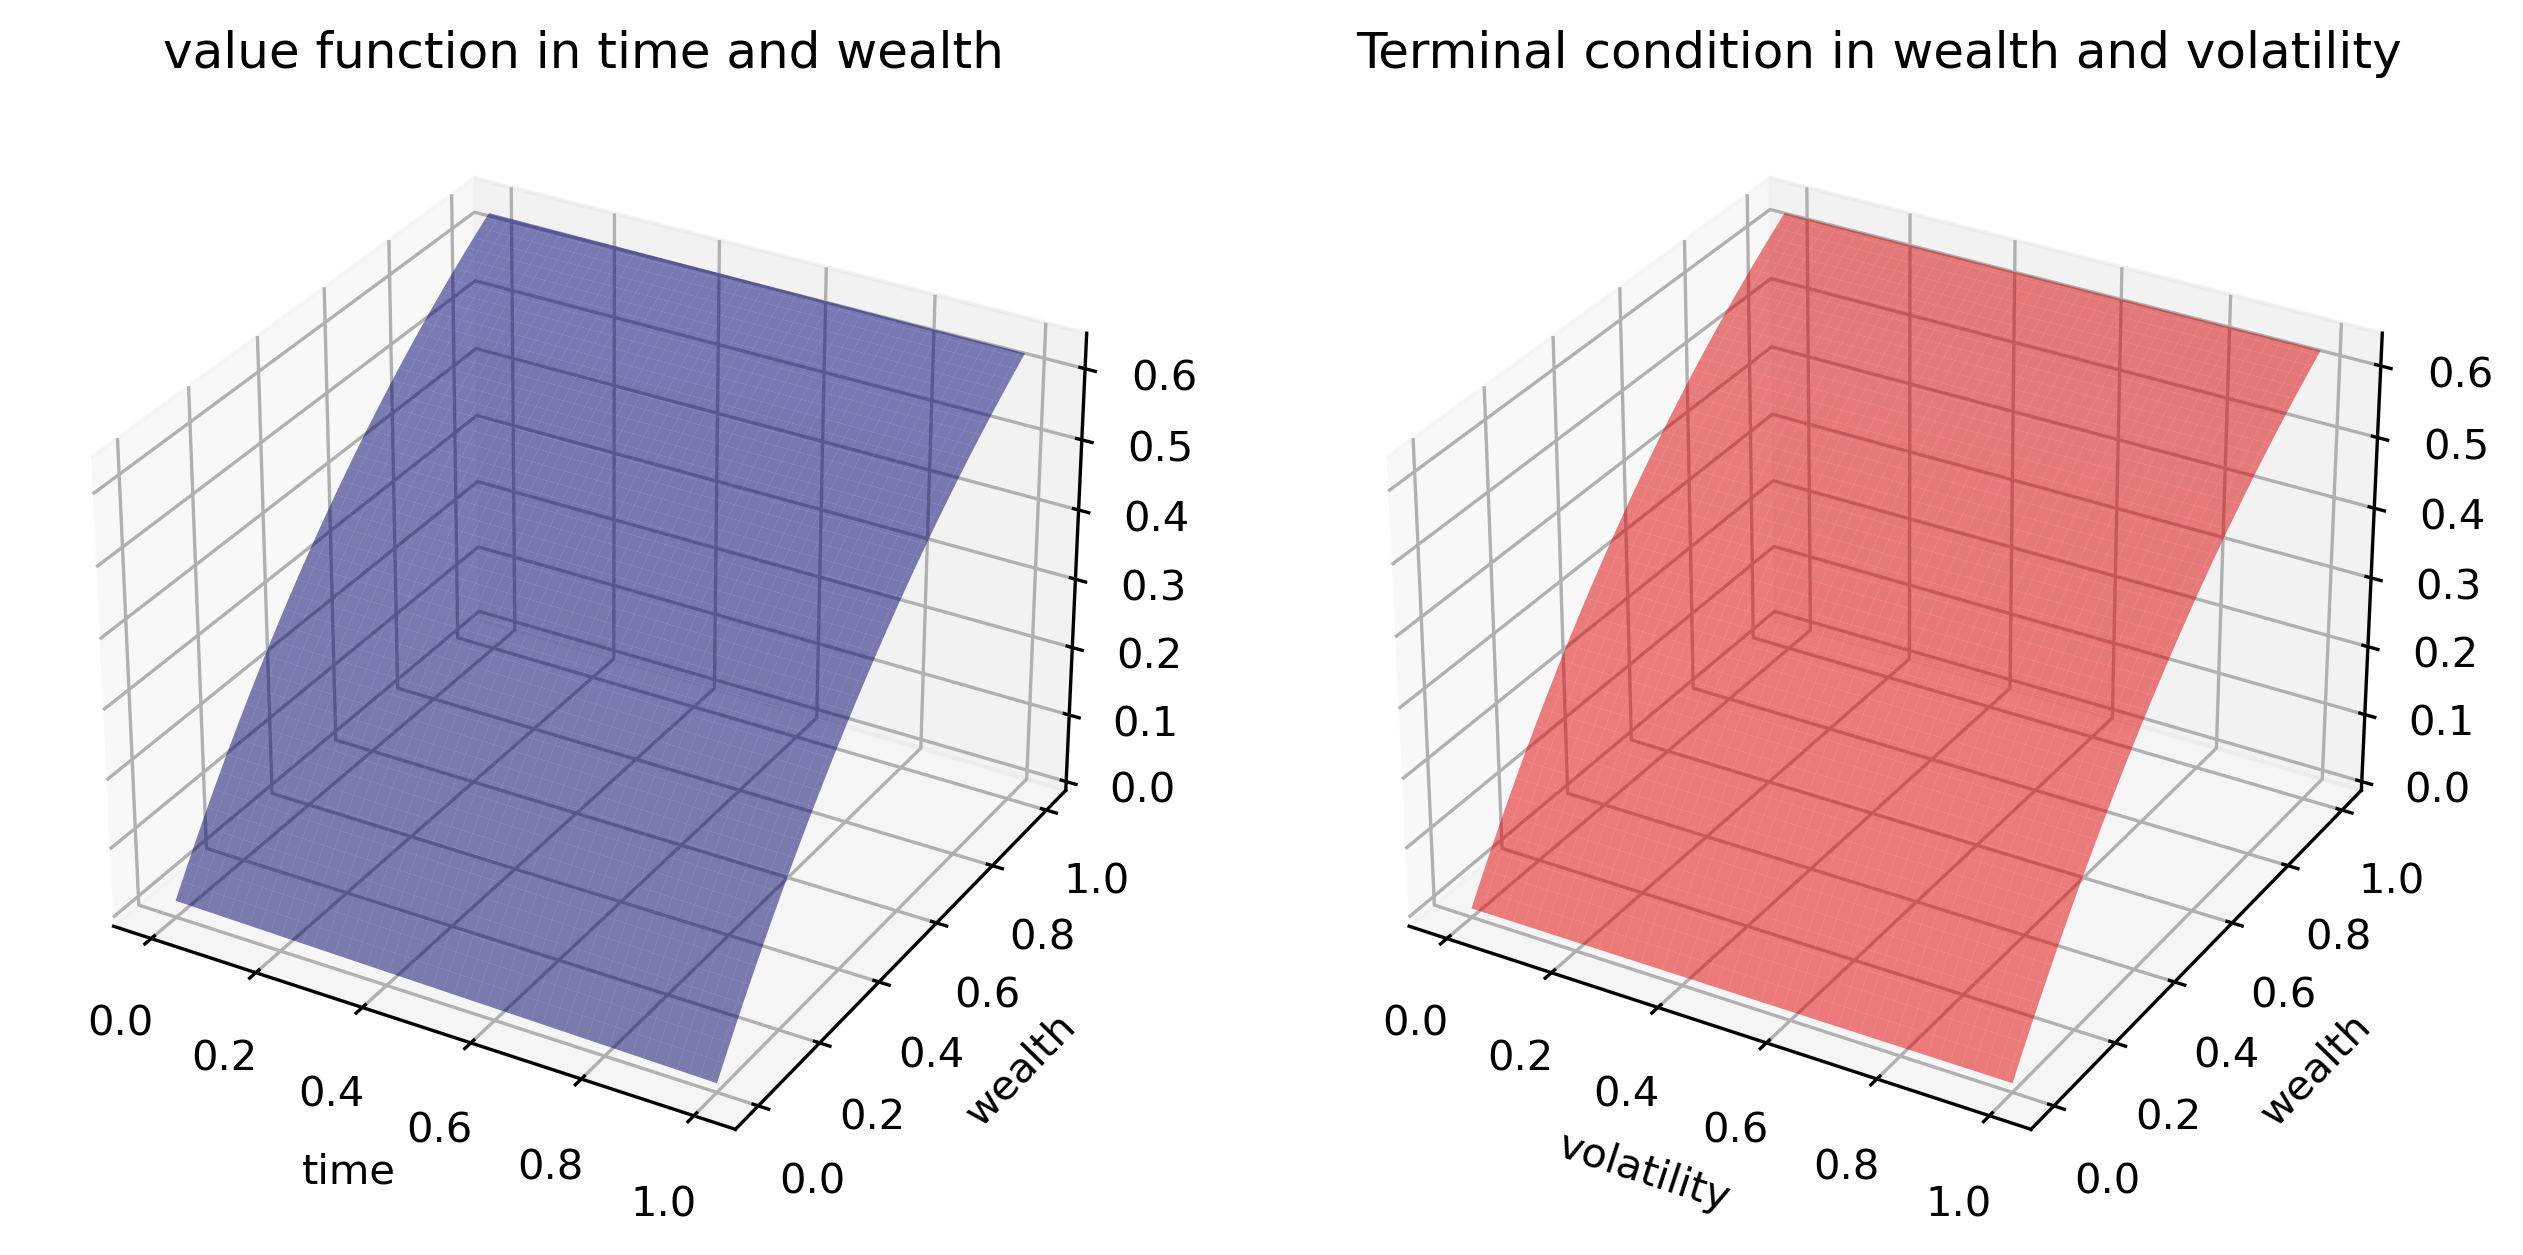

In [67]:
steps =100
x = torch.linspace(0.0,1.,steps=steps)
y = torch.linspace(0.0,1.,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
v_T = g(xy).detach().reshape(steps,steps).squeeze(-1)
v = sol_exp(xy).detach().reshape(steps,steps).squeeze(-1)
f = plt.figure(figsize=(10,3),dpi=300);
ax0 = f.add_subplot(1, 2, 1, projection='3d')
ax0.plot_surface(x.numpy(),y.numpy(),v.numpy(),color='b',alpha=0.5);
ax0.set_xlabel('time')
ax0.set_ylabel('wealth')
ax0.set_title("value function in time and wealth")

ax1 = f.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(y.numpy(),x.numpy(),v_T.numpy(),color='r',alpha=0.5);
ax1.set_ylabel('wealth')
ax1.set_xlabel('volatility');
ax1.set_title("Terminal condition in wealth and volatility")
plt.tight_layout(rect=(-0., -0.2, 1, 1.2));


# Sample generation based using defined coefficients

In [68]:
class data_gen(object):
    def __init__(self,sigma,mu,pde,sim):
        self.mu = mu
        self.sigma = sigma
        a = sim['start']
        b = sim['end']
        iid = sim['iid']
        num_samples = sim['num_samples']
        n = sim['num_time_intervals']
        dim = pde['dim']
        self.dt = torch.tensor([pde['T']/sim['num_time_intervals']]).to(device)
        dw = iid[0:num_samples*dim*n].reshape([num_samples,dim,n]).to(device)* torch.sqrt(self.dt)#you can make randomness a universal variable if 
        self.x = torch.zeros((num_samples,dim+1,n+1))
        
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)  
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt

In [69]:
v = sample_Znet()
s = sigma1D(pde_params)
sigma = NN_diff_1D(pde_params,diff = s)
mu =OU_drift_lin (pde_params,v,sigma)
a = torch.tensor([0.0])
b = torch.tensor([1.0])
T = pde_params['T']
n = 20
num_samples = 2**14

In [70]:
sigma(input).shape

torch.Size([10, 2, 2])

In [71]:
data = data_gen(sigma,mu,pde_params,sim_params)
data.x.shape

torch.Size([4096, 3, 21])

# Testing different update methods

# Solving linear equations

$\begin{cases}-\partial v_t - \dfrac12 (\sigma^\intercal\sigma): D^2v -\mu\cdot\nabla v + f(t,x) =0\\
v(T,x)=g(x)
\end{cases}$

$\sigma(t,x)$ has shape [num_samples,dim,dim]
$dW_t$  has shape [num_samples,dim]

We need to unsqueeze $dW_t$ before batch multiplication.

    
    torch.bmm(sigma(x[:,:,i]),dw[:, :, i]dw[:, :, i].unsqueeze(2))



In [72]:
class linear(object):
    def __init__(self,sigma,mu,source,kappa,terminal,pde,sim):        
        self.Y0 = Ynet() # NN for value at t=0 
        self.Z = Znet() # NN for gradient at all times
        self.Yt = Ytnet() # NN for value function at all times, required to update sigma
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.epoch=0 # initializing epoch to zero
        # self.num_epochs = 5000 # total number of epochs
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.source = source # source term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        data = data_gen(sigma,mu,pde,sim)
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.c = torch.ones((self.x.shape[0],1,n+1)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.r = self.r.clone().detach()
        self.c = self.c.clone().detach()
        self.trained = False
        
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*self.r[:,:,i] - self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
        
    def train(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while (torch.abs(L_-loss)>delta_loss) & (self.epoch < max_num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if (self.epoch % int(max_num_epochs/10)== int(max_num_epochs/10)-1) | (self.epoch == 0):
                print("The MSE at epoch {} is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0, t_1)
            self.epoch += 1
        print("Training took {} epochs and {:,} ms and the final loss is {:.2E}.".format(self.epoch,round(1000*(time.time()-t_0),2),loss))
        self.trained = True
        self.value_fnc(lr=1e-2,delta_loss=loss/10,max_num_epochs=500)

    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:,} ms. So far: {:,} ms in training.".format(round(1000*(time.time()-t_1),2),round(1000*(time.time()-t_0),2)))
        
        
    def value_fnc(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        if self.trained == False:
            print("The neural nets are not trained yet. Train the neural nets by running self.train(lr,delta_loss,max_num_epochs).")
        else:
            for i in range(self.n):   
                if i == 0:
                    Y =  self.Y0(self.x[:,1:,0])
                    x_data = self.x[:,:,i]
                    y_data = Y
                else:
                    if i == self.n - 1:
                        Y = self.terminal(self.x[:,1:,i+1])
                        x_data = torch.cat((x_data,self.x[:,:,i+1]),axis=0)
                        y_data = torch.cat((y_data,Y),axis=0)
                        #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
                    Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)        
                    x_data = torch.cat((x_data,self.x[:,:,i]),axis=0)
                    y_data = torch.cat((y_data,Y),axis=0)
            print("Data for value function is gathered in {:,} ms.".format(round(1000*(time.time()-t_0),2)))
    
            y_data = y_data.clone().detach()
            x_data = x_data.clone().detach()
            parameters = self.Yt.parameters()
            optimizer = optim.Adam(parameters, lr)
            L_ = torch.Tensor([-2.0])
            loss = torch.Tensor([2.0])
            initiation = True # to print the first epoch or last epoch in multiple rounds of training
            epoch=0
            # loss_epoch = []
            # max_num_epochs = 500
            t_0 = time.time()
            while (torch.abs(L_-loss)>delta_loss) & (epoch < max_num_epochs):# epoch in range(num_epochs):
                optimizer.zero_grad()
                if epoch>0:
                    L_ = loss
                loss= torch.pow(self.Yt(x_data)-y_data,2).mean()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
                loss.backward()
                optimizer.step()
                # loss_epoch.append(loss)
                
                if initiation:
                    initiation = False
                    print("\nFitting a neural net to the data initiated.")
                    print("The L^2 error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                if (epoch % int(max_num_epochs/100)== int(max_num_epochs/100)-1):    
                    print("The $L^2$-norm of the error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                epoch += 1
            print("Value function is evaluated in {:,} ms.".format(round(1000*(time.time()-t_0),2)))

In [73]:
# v = sample_Znet()
# s = sigma1D(pde_params)
# sigma = NN_diff_1D(pde_params,diff = s) 
sigma = constant_diff(pde_params,constant_diff = torch.tensor([0.2]))# With large constant_diff the trainning sucks!
# mu = OU_drift_lin(pde_params,v,sigma)
mu = OU_drift_semi(pde_params)
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = exponential_terminal(pde_params)
# g = zero_terminal(pde_params)
a = sim_params['start']
b = sim_params['end']

In [74]:
heat = linear(sigma,mu,f,k,g,pde_params,sim_params)

In [75]:
heat.value_fnc(lr=1e-2,delta_loss=1e-10,max_num_epochs=500)

The neural nets are not trained yet. Train the neural nets by running self.train(lr,delta_loss,max_num_epochs).


In [76]:
heat.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

The MSE at epoch 1 is 5.96E-01.
Training this epoch takes 40.89 ms. So far: 1,490.01 ms in training.
The MSE at epoch 500 is 9.54E-04.
Training this epoch takes 30.92 ms. So far: 19,653.48 ms in training.
The MSE at epoch 1000 is 9.26E-04.
Training this epoch takes 35.9 ms. So far: 40,329.23 ms in training.
The MSE at epoch 1500 is 9.15E-04.
Training this epoch takes 38.89 ms. So far: 59,870.7 ms in training.
The MSE at epoch 2000 is 9.08E-04.
Training this epoch takes 36.9 ms. So far: 80,051.82 ms in training.
The MSE at epoch 2500 is 9.04E-04.
Training this epoch takes 35.9 ms. So far: 100,958.5 ms in training.
The MSE at epoch 3000 is 9.01E-04.
Training this epoch takes 31.91 ms. So far: 118,622.78 ms in training.
The MSE at epoch 3500 is 8.98E-04.
Training this epoch takes 27.93 ms. So far: 136,409.26 ms in training.
Training took 3728 epochs and 143,990.02 ms and the final loss is 8.96E-04.
Data for value function is gathered in 24.93 ms.

Fitting a neural net to the data initiate

In [77]:
heat.value_fnc(lr=1e-2,delta_loss=1e-7,max_num_epochs=1000)
# print(heat.x_data.shape,heat.y_data.shape)

Data for value function is gathered in 58.85 ms.

Fitting a neural net to the data initiated.
The L^2 error of the fitted value function at epoch 1 is 1.40E-01.
The $L^2$-norm of the error of the fitted value function at epoch 10 is 9.90E-02.
The $L^2$-norm of the error of the fitted value function at epoch 20 is 6.03E-02.
The $L^2$-norm of the error of the fitted value function at epoch 30 is 4.90E-02.
The $L^2$-norm of the error of the fitted value function at epoch 40 is 4.92E-02.
The $L^2$-norm of the error of the fitted value function at epoch 50 is 4.64E-02.
The $L^2$-norm of the error of the fitted value function at epoch 60 is 4.61E-02.
The $L^2$-norm of the error of the fitted value function at epoch 70 is 4.51E-02.
The $L^2$-norm of the error of the fitted value function at epoch 80 is 4.46E-02.
The $L^2$-norm of the error of the fitted value function at epoch 90 is 4.41E-02.
The $L^2$-norm of the error of the fitted value function at epoch 100 is 4.36E-02.
The $L^2$-norm of 

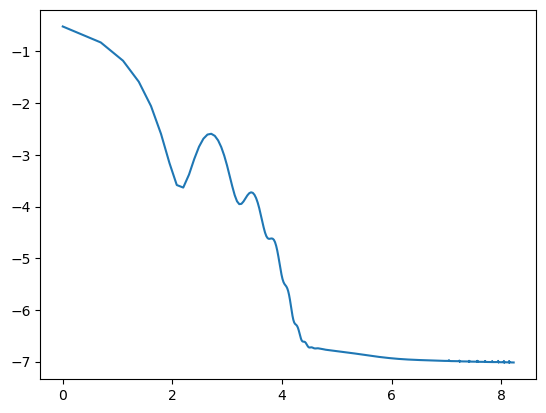

In [78]:
plt.plot(np.log(np.arange(len(heat.loss_epoch))+1),[np.log(l.detach().numpy()) for l in heat.loss_epoch]);

## Plot value function

In [81]:
def display_it(eqn):
    sol_exp = solution(pde_params0)
    if dim == 2:
        steps =100
        x = torch.linspace(0.5,0.7,steps=steps)
        y = torch.linspace(0.5,0.7,steps=steps)
        xy = torch.cartesian_prod(x,y)
        txy = torch.cat((torch.zeros(xy.shape[0],1),xy),axis=1)
        # v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
        v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
        v_ = eqn.Yt(txy).detach().reshape(steps,steps).squeeze(-1)
        v_0 = sol_exp(txy).detach().reshape(steps,steps).squeeze(-1)
        f,ax = plt.subplots(1,1,figsize=(8,4),dpi=300);
        ax = plt.axes(projection='3d')
        X, Y = torch.meshgrid(x, y, indexing='ij')
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v_.numpy(),alpha=0.5,label="fitted",color='r');
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v_0.numpy(),alpha=0.5,label='closed-form',color='g');
        ax.set_xlabel('wealth')
        ax.set_ylabel('volatility');
        ax.set_zlim((-0.1,0.8))
        # surf._edgecolors2d = surf._edgecolor3d
        # surf._facecolors2d = surf._facecolor3d
        fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o',alpha=0.5)
        fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o',alpha=0.5)
        fake2Dline3 = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o',alpha=0.5)
        ax.legend([fake2Dline1, fake2Dline2, fake2Dline3], ["approximation", "fitted", "closed-form"], numpoints = 1, loc=(0.2,0.7))
        plt.tight_layout(rect=[0,0,1,1]);      
    data = torch.rand(2**14,dim)
    tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
    v_ = eqn.Yt(tdata).detach().squeeze(-1)
    v = eqn.Y0(data).detach().squeeze(-1)
    v_0 = sol_exp(tdata).detach().squeeze(-1)
    print("The $L^2$ distance between the fitted value function and closed form is  {:.3E}.".format(pow(v_-v_0,2).mean()))  
    print("The $L^2$ distance between the approximated value function and closed form is  {:.3E}.".format(pow(v-v_0,2).mean()))  




The $L^2$ distance between the fitted value function and closed form is  5.451E-04.
The $L^2$ distance between the approximated value function and closed form is  4.007E-04.


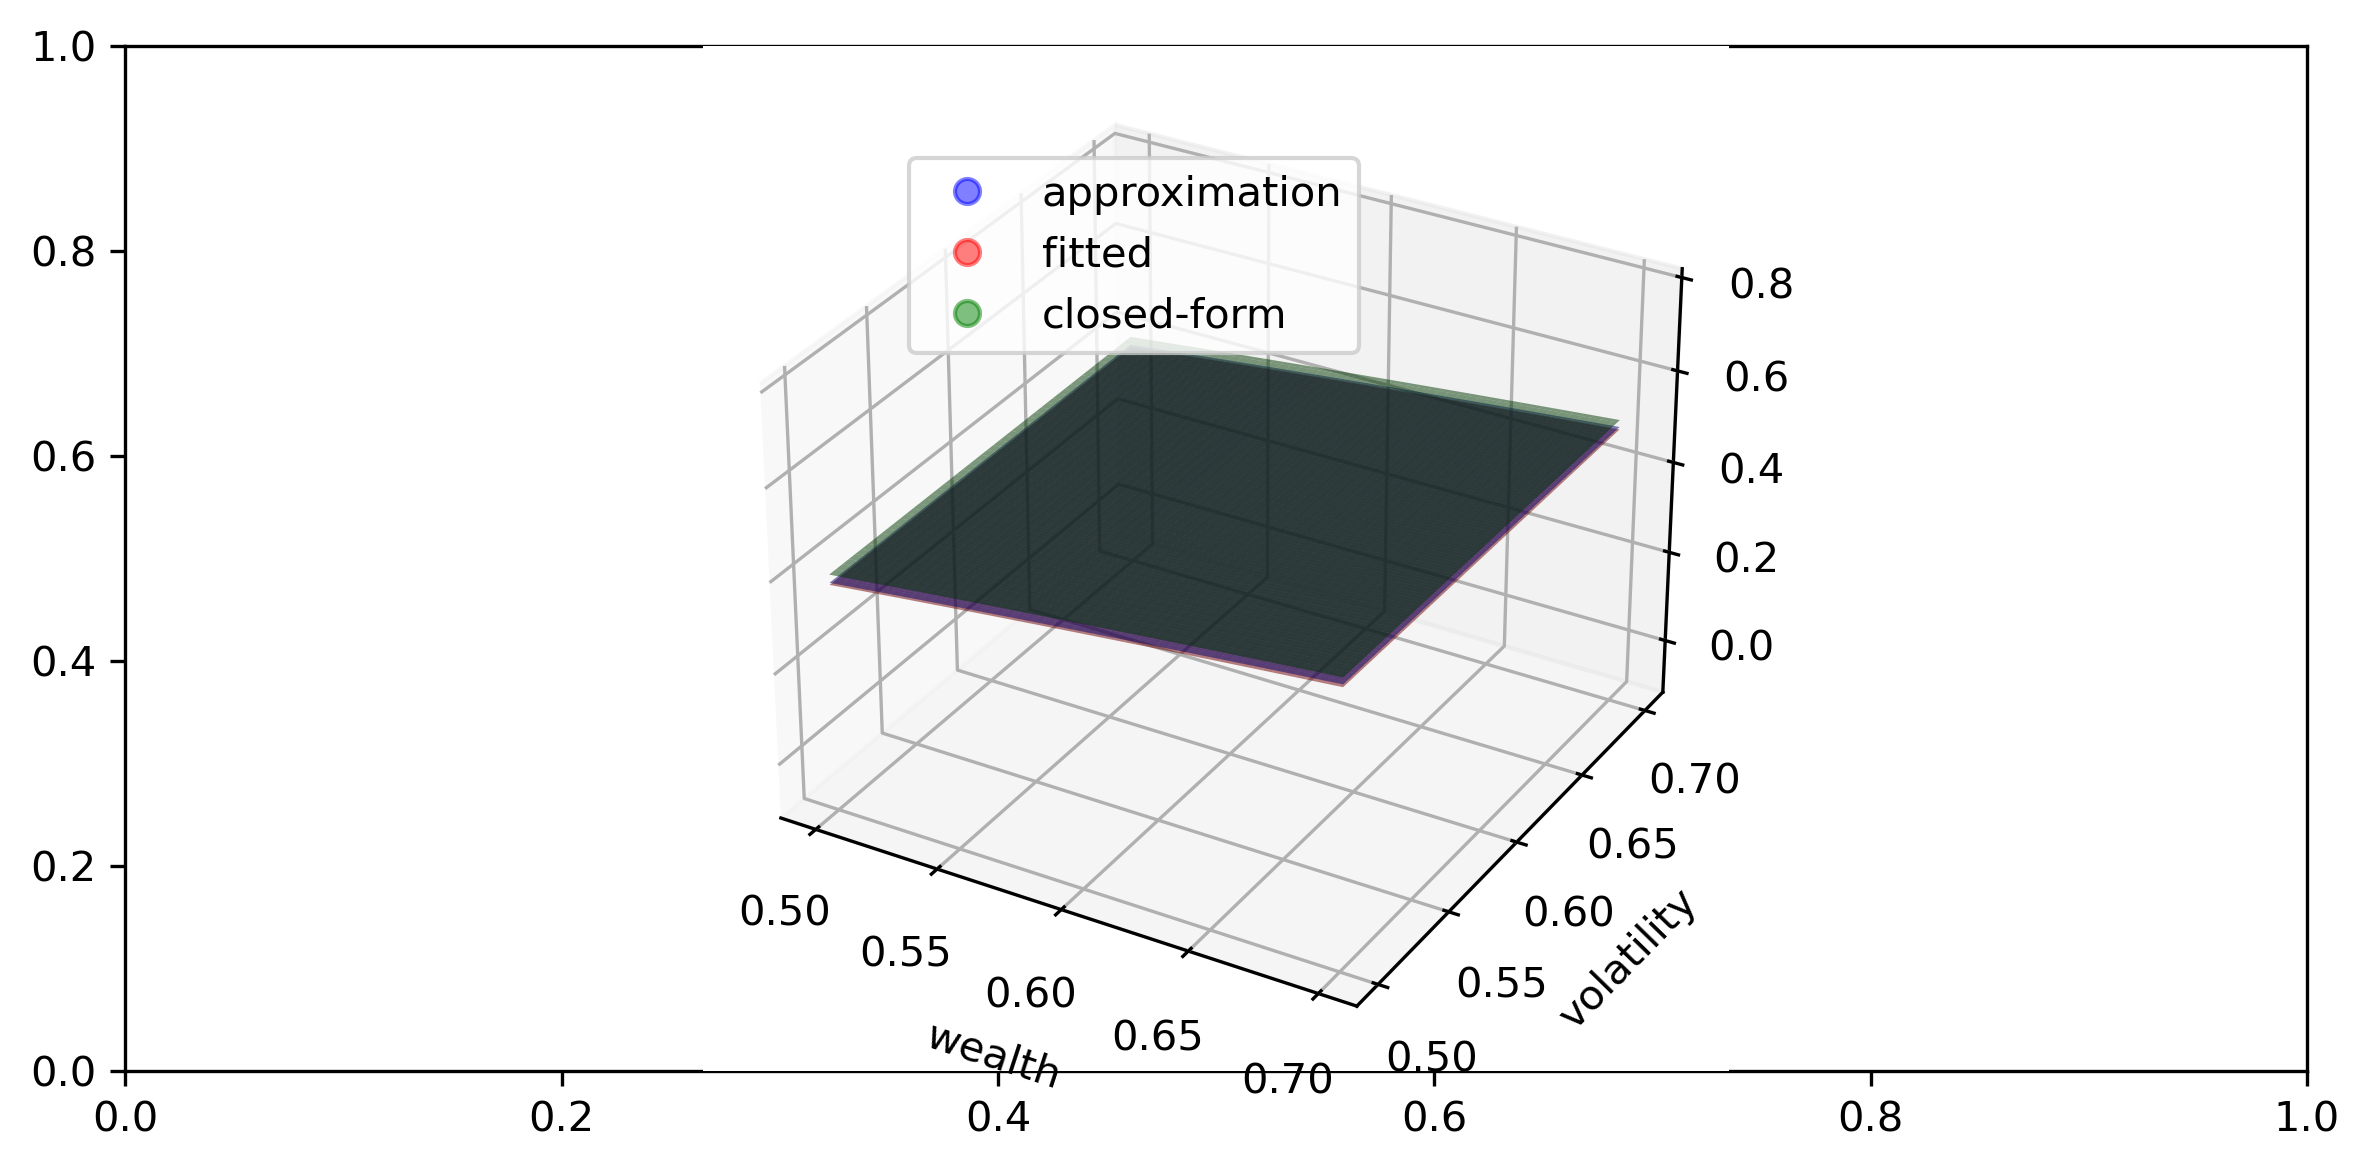

In [82]:
display_it(heat);

## Testing update of $\sigma_n$

In [83]:
sigma_1 = NN_diff_1D(pde_params,diff = sigma, update = u)

# Solving semilinear equatoins

In [104]:
class semilinear(object):
    def __init__(self,sigma,mu,F,kappa,terminal,pde,sim):
        self.Y0 = Ynet() # NN for value at t=0 
        self.Z = Znet() # NN for gradient at all times 
        self.Yt = Ytnet() # NN for value function at all times, required to update sigma
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.num_epochs = 5000 # total number of epochs
        self.epoch=0 # initializing epoch to zero
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.F = F # nonlinear term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        data = data_gen(sigma,mu,pde,sim)
        self.num_samples = sim['num_samples']
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.Y = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.sigmax = torch.ones((self.x.shape[0],dim,dim,n)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            self.sigmax[:,:,:,i] = self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))
        self.r = self.r.clone().detach()
        self.sigmax = self.sigmax.clone().detach()
        self.trained = False
        
        
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                if i == self.n - 1:
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
                    #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
                c[:,:,i] = self.F(self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigmax[:,0,0,i]).unsqueeze(-1)
                Y = Y*self.r[:,:,i] + c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(c[:,:,-1]-Y,2).mean()
        
    def train(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        initiation = True # to print the first epoch or last epoch in multiple rounds of training
        while (torch.abs(L_-loss)>delta_loss) & (self.epoch < max_num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            if (self.epoch % int(max_num_epochs/10)== int(max_num_epochs/10)-1) | initiation:
                initiation = False
                print("At epoch {} the mean error is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0, t_1)
            self.epoch += 1
        print("Training took {} epochs.".format(self.epoch))
        self.trained = True
        self.value_fnc(lr=1e-2,delta_loss=loss/10,max_num_epochs=500)
        
    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:,} ms.".format(round(1000*(time.time()-t_1),2)))
        print("So far: {:,} ms in training.".format(round(1000*(time.time()-t_0),2)))
        
    def value_fnc(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        if self.trained == False:
            print("The neural nets are not trained yet. Train the neural nets by running self.train(lr,delta_loss,max_num_epochs).")
        else:
            for i in range(self.n):   
                if i == 0:
                    Y =  self.Y0(self.x[:,1:,0])
                    x_data = self.x[:,:,i]
                    y_data = Y
                else:
                    if i == self.n - 1:
                        Y = self.terminal(self.x[:,1:,i+1])
                        x_data = torch.cat((x_data,self.x[:,:,i+1]),axis=0)
                        y_data = torch.cat((y_data,Y),axis=0)
                        #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
                    self.c[:,:,i] = self.F(self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigmax[:,0,0,i]).unsqueeze(-1)
                    Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)        
                    x_data = torch.cat((x_data,self.x[:,:,i]),axis=0)
                    y_data = torch.cat((y_data,Y),axis=0)
            print("Data for value function is gathered in {:,} ms.".format(round(1000*(time.time()-t_0),2)))
    
            y_data = y_data.clone().detach()
            x_data = x_data.clone().detach()
            parameters = self.Yt.parameters()
            optimizer = optim.Adam(parameters, lr)
            L_ = torch.Tensor([-2.0])
            loss = torch.Tensor([2.0])
            initiation = True # to print the first epoch or last epoch in multiple rounds of training
            epoch=0
            # loss_epoch = []
            # max_num_epochs = 500
            t_0 = time.time()
            while (torch.abs(L_-loss)>delta_loss) & (epoch < max_num_epochs):# epoch in range(num_epochs):
                optimizer.zero_grad()
                if epoch>0:
                    L_ = loss
                loss= torch.pow(self.Yt(x_data)-y_data,2).mean()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
                loss.backward()
                optimizer.step()
                # loss_epoch.append(loss)
                
                if initiation:
                    initiation = False
                    print("\nFitting a neural net to the data initiated.")
                    print("The L^2 error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                if (epoch % int(max_num_epochs/100)== int(max_num_epochs/100)-1):    
                    print("The $L^2$-norm of the error of the fitted value function at epoch {} is {:.2E}.".format(epoch+1,torch.sqrt(loss.detach())))
                epoch += 1
            print("Value function is evaluated in {:,} ms.".format(round(1000*(time.time()-t_0),2)))


In [105]:
# sigma = sigma1D(pde_params)
# s = NN_diff_1D(pde_params, diff = sigma) 
s = constant_diff(pde_params,constant_diff = torch.tensor([0.1]))
m = OU_drift_semi(pde_params)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [106]:
semi = semilinear(s,m,F,k,g,pde_params,sim_params)

In [107]:
semi.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1 the mean error is 2.99E-02.
Training this epoch takes 100.73 ms.
So far: 100.73 ms in training.
At epoch 500 the mean error is 2.35E-04.
Training this epoch takes 80.78 ms.
So far: 39,191.04 ms in training.
At epoch 1000 the mean error is 2.30E-04.
Training this epoch takes 72.8 ms.
So far: 74,567.48 ms in training.
At epoch 1500 the mean error is 2.46E-04.
Training this epoch takes 67.82 ms.
So far: 110,452.52 ms in training.
At epoch 2000 the mean error is 2.25E-04.
Training this epoch takes 69.81 ms.
So far: 153,538.73 ms in training.
At epoch 2500 the mean error is 2.24E-04.
Training this epoch takes 69.81 ms.
So far: 191,272.77 ms in training.
At epoch 3000 the mean error is 2.23E-04.
Training this epoch takes 67.82 ms.
So far: 229,350.5 ms in training.
Training took 3029 epochs.


NameError: name 'c' is not defined

In [99]:
semi.value_fnc(lr=1e-2,delta_loss=2.27E-05,max_num_epochs=500)

AttributeError: 'semilinear' object has no attribute 'c'

## Plot value function 2D

In [92]:
display_it(semi)

AttributeError: 'semilinear' object has no attribute 'Yt'

In [ ]:
# plt.plot([l.detach().numpy() for l in semi.loss_epoch]);

In [ ]:
f = plt.figure(figsize=(10,10),dpi=300)
plt.plot(np.log(np.arange(len(semi.loss_epoch))+1),[np.log(l.detach().numpy()) for l in semi.loss_epoch]);
plt.suptitle("Log-log plot of loss function vs # of epochs");

# Testing different update methods

## Approximating value function 

We get $V(0,x)$ and $\nabla V(t,x)$ and try to recover $V(t,x)$ as a separate NN!

In [ ]:
Yt = heat.Yt
print(heat.x.shape)

In [ ]:
for i in range(heat.x.shape[2]):
    if i == 0:
        x_data = heat.x[:,:,i]
    else: 
        x_data = torch.cat((x_data,heat.x[:,:,i]),axis=0)
x_data = x_data.clone().detach()
# y_data = y_data.clone().detach()

In [ ]:
# parameters = Yt.parameters()
# optimizer = optim.Adam(parameters, lr=1e-2)
# L_ = torch.Tensor([-2.0])
# loss = torch.Tensor([2.0])
# initiation = True # to print the first epoch or last epoch in multiple rounds of training
# epoch=0
# max_num_epochs = 500
# t_0 = time.time()
# while (torch.abs(L_-loss)>1e-10) & (epoch < max_num_epochs):# epoch in range(num_epochs):
#     if epoch>0:
#         L_ = loss
#     t_1 = time.time()
#     optimizer.zero_grad()
#     loss= torch.pow(Yt(x_data)-y_data,2).mean()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
#     loss.backward()
#     optimizer.step()
#     loss_epoch.append(loss)
#     if (epoch % int(max_num_epochs/100)== int(max_num_epochs/100)-1) | initiation:
#         initiation = False
#         print("At epoch {} the mean error is {:.2E}.".format(epoch+1,loss.detach()))
#         print("Training this epoch takes {:,} ms.".format(round(1000*(time.time()-t_1),2)))
#         print("So far: {:,} ms in training.".format(round(1000*(time.time()-t_0),2)))    
#     epoch += 1
# print("Training took {:,} ms.".format(round(1000*(time.time()-t_0),2)))

In [ ]:
def display_value(eqn):
    sol_exp = solution(pde_params)
    if dim == 2:
        steps =100
        x = torch.linspace(0.0,1.,steps=steps)
        y = torch.linspace(0.0,1.,steps=steps)
        xy = torch.cartesian_prod(x,y)
        txy = torch.cat((0*torch.ones(xy.shape[0],1),xy),axis=1)
        # v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
        v = Yt(txy).detach().reshape(steps,steps).squeeze(-1)
        v_0 = sol_exp(txy).detach().reshape(steps,steps).squeeze(-1)
        f,ax = plt.subplots(1,1,figsize=(5,5),dpi=300);
        ax = plt.axes(projection='3d')
        X, Y = torch.meshgrid(x, y, indexing='ij')
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation");
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v_0.numpy(),color='r',alpha=0.5,label='closed-form');
        ax.set_xlabel('wealth')
        ax.set_ylabel('volatility');
        ax.set_zlim((-0.5,0.8))
        # surf._facecolors2d = surf._facecolors3d
        # surf._edgecolors2d = surf._edgecolors3d
        # ax.legend();
        plt.tight_layout(rect=[0,0,1,1]);      
    tdata = torch.rand(2**14,dim+1)
    v = Yt(tdata).detach().squeeze(-1)
    # tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
    v_0 = sol_exp(tdata).detach().squeeze(-1)
    print("The MSE is {:.3E}.".format(pow(v-v_0,2).mean()))  

In [ ]:
display_value(heat)

Now, let's evaluate the gradient of Yt excluding time and compare it with Z.

In [ ]:
x_data.shape

In [ ]:
# print("{:E}".format(torch.pow(x_jacobian(Yt,x_data[0:4096,:])-heat.Z(x_data[0:4096,:]),2).mean()))

In [ ]:
for i in range(heat.x.shape[2]):
    if i == 0:
        x_data = heat.x[:,:,i]
    else: 
        x_data = torch.cat((x_data,heat.x[:,:,i]),axis=0)
# sqr_jacobian(heat.Z,x_data)
x_data.shape

In [ ]:
for i in range(heat.x.shape[2]):
    if i == 0:
        out = sqr_jacobian(heat.Z,heat.x[:,:,i])
    else: 
        out = torch.cat((out,sqr_jacobian(heat.Z,heat.x[:,:,i])),axis=0)

**I have speed problem using Jacobian in torch. I am going to stick with the Grad_Hess function written by Hung.**

It can certainly go faster if we only evaluate the derivatives that we need. But, I am not going to go down that road.

## Source evaluation for the linear equation

In [ ]:
D2 = Grad_Hess(x_data,Yt)[1][:,1:,1:]
D1 = Grad_Hess(x_data,Yt)[0][:,1:]
D1.shape,D2.shape

In [ ]:
def Frobenius(A,B):
    return torch.vmap(torch.trace)(torch.bmm(A,torch.transpose(B,1,2)))

In [ ]:
A = torch.zeros(x_data.shape[0],dim,dim)
A[:,0,0] = torch.sqrt(torch.pow(pde_params0['lb'][0:dim],dim).sum())*D1[:,1].squeeze(-1)#
A = A-torch.bmm(heat.sigma(x_data),D2)
Frobenius(A,A).shape

In [ ]:
out[0,:,:],D2[0,:,:],x_data[0,:]

In [ ]:
torch.transpose(D2,1,2)

In [ ]:
batch_trace1 = torch.vmap(torch.trace)(torch.bmm(out,torch.transpose(out,1,2)))
batch_trace2 = torch.vmap(torch.trace)(torch.bmm(D2,torch.transpose(D2,1,2)))
torch.pow(batch_trace1-batch_trace2,2).mean()

In [ ]:
A = torch.zeros(x_data.shape[0],2,2)
A[:,0,0] = torch.sqrt(torch.pow(pde_params0['lb'][0:dim],2).sum())*Grad_Hess(x_data,Yt)[0][:,1].squeeze(-1)#

In [ ]:
B = A-torch.bmm(heat.sigma(x_data),Grad_Hess(x_data,Yt)[1][:,1:,1:])
Frobenius(B,A).shape

In [ ]:
torch.vmap(torch.trace)(torch.bmm(B,torch.transpose(B,1,2)))

In [ ]:
Grad_Hess(x_data,Yt)[0][:,1].shape,heat.x.shape,heat.sigma(heat.x[:,:,0]).shape

In [ ]:
stop here 

# Combine both linear and semilinear

In [ ]:
class eqn(object):
    def __init__(self,params,sigma,mu,kappa,terminal): #params=dim,T,n,a,b,num_samples
        self.dim = params['dim']
        self.T = params['T']
        self.num_samples = params['num_samples']
        self.n = params['num_steps']
        self.a = params['a']
        self.b = params['b']
        self.loss_epoch = []
        self.num_epochs = 10000
        self.epoch=0
        self.sigma = sigma         
        self.mu = mu
        self.kappa = kappa 
        self.terminal = terminal
        self.x = torch.zeros((self.num_samples,self.dim+1,self.n+1))
        self.dt = torch.tensor([self.T/self.n]).to(device)
        self.Y0 = Ynet()
        self.Z = Znet()
        self.dw = torch.randn(size=[self.num_samples, self.dim, self.n]).to(device)* torch.sqrt(self.dt)
        self.x[:,1:,0]= self.a+(self.b-self.a)*torch.rand(self.num_samples,self.dim).to(device)
        self.r = torch.ones((self.num_samples,1,self.n+1)).to(device)
        self.sigmadw = torch.zeros((self.num_samples,self.dim,self.n)).to(device)
        for i in range(self.n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((self.num_samples,self.dim,self.dim)),self.dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
        self.x = self.x.clone().detach()
        self.r = self.r.clone().detach()
        self.sigmadw = self.sigmadw.clone().detach()
        
        
    def train(self):
        t_0 = time.time()
        self.lr = 1e-2
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while  (torch.abs(L_-loss)>1e-10) & (self.epoch < self.num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()##
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            if (self.epoch % int(self.num_epochs/10)== int(self.num_epochs/10)-1):
                print("At epoch {} the mean loss is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0,t_1)          
            self.epoch += 1
        print("Training took {} epochs.".format(self.epoch))
            
                
    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:.3E} ms.".format(round(1000*(time.time()-t_1),2)))
        print("So far: {:.3E} ms in training.".format(round(1000*(time.time()-t_0),2)))    

class lin(eqn):
    def __init__(self,params,sigma,mu,kappa,terminal,source):
        self.source = source    
        super(lin,self).__init__(params,sigma,mu,kappa,terminal)
        self.c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
            self.c = self.c.clone().detach()

            
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*self.r[:,:,i] - self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                # print(Y)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
    
class semi(eqn):
    def __init__(self,params,sigma,mu,kappa,terminal,F):
        self.F = F    
        super(semi,self).__init__(params,sigma,mu,kappa,terminal)

            
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                if i == self.n - 1:
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
                c[:,:,i] = self.F.eval(self.x[:,1:,i].unsqueeze(-1),self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0]).unsqueeze(-1)
                Y = Y*self.r[:,:,i] - c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                # print(Y)
        return torch.pow(c[:,:,-1]-Y,2).mean()        

In [ ]:
x=torch.rand((8,dim+1))
s = NN_diff_1D(pde_params)
m = OU_drift_semi(pde_params)
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = terminal(pde_params)

In [ ]:
lin_eqn = lin(pde_params,s,m,k,g,f)

In [ ]:
lin_eqn.n

In [ ]:
lin_eqn.train()

## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = lin.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = lin.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = lin.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = lin.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
semi1 = semi(params,s,m,k,expo,F)

In [ ]:
semi1.train()

## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi1.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = semi1.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi1.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = semi1.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


# Finding second derivative

In [ ]:
import torch
from torch.autograd import grad
 
def test_fn(x):
    return torch.bmm(x.unsqueeze(-1),x.unsqueeze(1)).unsqueeze(-1)

x = torch.tensor([[0.0, 1.0],[1.0,0.0]], requires_grad=True)
 
# Compute the gradient of f with respect to x
def gradiant(x,f):
    return grad(outputs=f(x), inputs=x, grad_outputs=torch.ones_like(f(x)), create_graph=True, retain_graph=True, only_inputs=True)[0]#.unsqueeze(-1)
 
# Print the gradient
print(gradiant(x,test_fn).shape)

In [ ]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(-1)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [ ]:
der1(x,test_fn).shape

In [ ]:
def Grad_Hess(x,f_): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x[:,1:].clone().detach()
    xin.requires_grad=True
    u=f_(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    return Du, hess_temp


In [ ]:
semi1.x[:,:,0].squeeze(-1).shape,x.shape

In [ ]:
x = torch.tensor([[0.0,0.0,1.0],[0.0,1.0,0.0],[0.0,1.4,0.7]], requires_grad=True)
Grad_Hess(semi1.x[:,:,0],semi1.Y0)[1].mean()

# test second derivative with NN

<font color="red" size="4">Batch normaizations srews up the derivative.</font>

In [ ]:
def Hess(x,f_): #output= [M,D,D], #input: x=[M,D]
    dim = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=f_(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    return Du, hess_temp

In [ ]:
class NN1d(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(NN1d, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 20),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(20,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim]) 

In [ ]:
test_fn = NN1d()

In [ ]:
x_tr = torch.rand(100,1)
# x_tr = torch.rand(0,1,100).unsqueeze(-1)
y_tr = x_tr*x_tr

In [ ]:
num_epochs = 100000
lr = 1e-2
optimizer = optim.Adam(test_fn.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while  (torch.abs(L_-loss)>1e-8) & (epoch < num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss= torch.pow(y_tr-test_fn(x_tr),2).mean()##
    loss.backward()
    optimizer.step()
    if (epoch % int(num_epochs/10)== int(num_epochs/10)-1):
        print("At epoch {} the mean loss is {}.".format(epoch+1,loss.detach()))
    epoch += 1

In [ ]:
x_ts = torch.linspace(0,1,100).unsqueeze(-1)
plt.plot(x_ts.detach().numpy(),test_fn(x_ts).detach().numpy());
plt.plot(x_ts.detach().numpy(),x_ts*x_ts.detach().numpy());

In [ ]:
xin = x_ts.clone().detach()
xin.requires_grad=True
dy = gradiant(xin,test_fn).squeeze(-1)
dy.shape

In [ ]:
# plt.plot(x_tr.detach().numpy(),test_fn(x_tr).detach().numpy());
plt.plot(x_ts.detach().numpy(),dy.detach().numpy());

In [ ]:
gradiant(torch.tensor([[1.0],[0.5],[0.0]],requires_grad=True),test_fn)

In [ ]:
ddy = Hess(x_ts,test_fn)[1].squeeze(-1)
plt.plot(x_ts.detach().numpy(),ddy.detach().numpy());

${\color{red}\text{It does not matter if the second derivative is not accurate. } \ell^2  \text{ will be positive and the direction is always a direction of increase.}}$